In [1]:
#!pip install scikit-image
#!pip install torchsummary

In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 2 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3

#TRAIN_PATH = '/content/drive/My Drive/UNet/Cell'
#TEST_PATH = '/content/drive/My Drive/UNet/Cell'

TRAIN_PATH = './Cell/Cell'
TEST_PATH = './Cell/Cell'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/chenzhong/miniconda3/envs/resnet_anzhe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'X.npy'

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split

#x, y, x_val, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
#split dataset to 80% 10% 10%
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]

# print(x.shape)
# print(y.shape)

########when label is matched delete this#######################
#x = x[:93]
#x_val = x_val[:93]
################################################################
x_train_tensor = torch.from_numpy(x)
y_train_tensor = torch.from_numpy(y)
# x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_train_tensor = x_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_train_tensor = y_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
#print(x_train_tensor.shape)
#print(y_train_tensor.shape)
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
# x_val_tensor = torch.tensor(x_val_tensor, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)
x_val_tensor = x_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_val_tensor = y_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


(-0.5, 127.5, 127.5, -0.5)

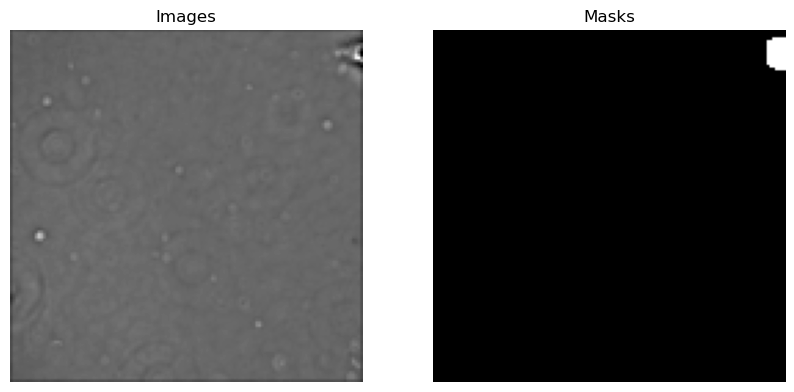

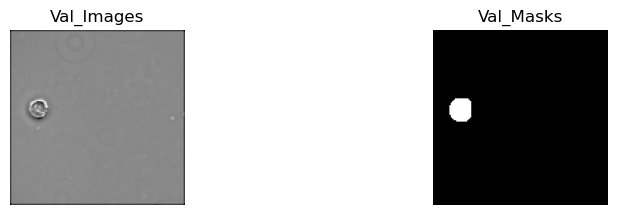

In [ ]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[0,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(y[0], cmap='gray')
plt.title("Masks")
plt.axis('off')

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[1,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(y_val[1], cmap='gray')
plt.title("Val_Masks")
plt.axis('off')

In [ ]:
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)

In [ ]:
# Define IoU metric
import torch

# def mean_iou(y_pred, y_true):
#     num_classes = y_true.size(1)
#     ious = []
    
#     for cls in range(num_classes):
#         intersection = torch.logical_and(y_true[:, cls, :, :], y_pred[:, cls, :, :]).sum()
#         union = torch.logical_or(y_true[:, cls, :, :], y_pred[:, cls, :, :]).sum()

#         iou = (intersection.float() + 1e-10) / (union.float() + 1e-10)
#         ious.append(iou)

#     mean_iou = torch.mean(torch.stack(ious))
#     return mean_iou.item()
def mean_iou(y_pred, y_true):
    prec = []
    
    for t in torch.arange(0.5, 1.0, 0.05):
        y_pred_ = (y_pred > t).float()
        y_true_ = y_true.float()

        intersection = torch.sum(y_true_ * y_pred_)
        union = torch.sum((y_true_ + y_pred_).clamp(0, 1))

        iou = intersection / union
        prec.append(iou.item())
    
    return torch.mean(torch.tensor(prec))

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output


In [ ]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [ ]:
c_in = 3  # input channel 3 for RGB
c_out = 1  # output channel
if torch.cuda.device_count() > 1:
    device1 = torch.device("cuda:0")
    device2 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=15, verbose=True)

In [ ]:
#print unet model summary

from torchsummary import summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

#print(model)
#print(f"Total Trainable Parameters: {count_parameters(model)}")
summary(model, (3, 128, 128), device= 'cpu')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
         GroupNorm-2         [-1, 64, 128, 128]             128
              GELU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,864
         GroupNorm-5         [-1, 64, 128, 128]             128
         ConvBlock-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
         GroupNorm-9           [-1, 64, 64, 64]             128
             GELU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,864
        GroupNorm-12           [-1, 64, 64, 64]             128
        ConvBlock-13           [-1, 64, 64, 64]               0
           Conv2d-14          [-1, 128,

In [ ]:
# Training loop
num_epochs = 100
model.to(device2)
best_loss = 1.0
best_iou = 0.0
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for inputs, labels in tqdm(train_loader):
        gpu = torch.cuda.get_device_properties(device2)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device2) > 0.9 * gpu.total_memory:
            model = model.to(device1)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device2)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device2), labels.permute(0, 3, 1, 2).to(device2)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        iou = mean_iou(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    if early_stopping(loss, model):
        print('Early stopping triggered')
        break
print(f'Best loss is {best_loss}, besst iou is {best_iou}')

100%|██████████| 7/7 [00:32<00:00,  4.69s/it]


Epoch [1/100] Loss: 0.33232502000672476 IoU: 0.0008992174906390053
Saving model...


100%|██████████| 7/7 [00:37<00:00,  5.38s/it]


Epoch [2/100] Loss: 0.2684537810938699 IoU: 0.0
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:38<00:00,  5.43s/it]


Epoch [3/100] Loss: 0.2578663251229695 IoU: 0.0
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.19s/it]


Epoch [4/100] Loss: 0.2534421363047191 IoU: 0.0
Saving model...


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Epoch [5/100] Loss: 0.24861853676182882 IoU: 0.0
Saving model...


100%|██████████| 7/7 [00:34<00:00,  4.97s/it]


Epoch [6/100] Loss: 0.23383663594722748 IoU: 0.003700179180928639
Saving model...


100%|██████████| 7/7 [00:37<00:00,  5.32s/it]


Epoch [7/100] Loss: 0.1906848336969103 IoU: 0.08422053182825298
Saving model...


100%|██████████| 7/7 [00:35<00:00,  5.07s/it]


Epoch [8/100] Loss: 0.15758569751467025 IoU: 0.15525758585759572
Saving model...


100%|██████████| 7/7 [00:37<00:00,  5.31s/it]


Epoch [9/100] Loss: 0.13625367943729674 IoU: 0.08696658164262772
Saving model...


100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Epoch [10/100] Loss: 0.12678206712007523 IoU: 0.2067506249461855
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.93s/it]


Epoch [11/100] Loss: 0.11526320768254143 IoU: 0.311759101493018
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.90s/it]


Epoch [12/100] Loss: 0.10516138694116048 IoU: 0.3521021476813725
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:32<00:00,  4.61s/it]


Epoch [13/100] Loss: 0.09370665571519307 IoU: 0.4074696557862418
Saving model...


100%|██████████| 7/7 [00:35<00:00,  5.07s/it]


Epoch [14/100] Loss: 0.09409299918583461 IoU: 0.380697563290596
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.19s/it]


Epoch [15/100] Loss: 0.08874194643327168 IoU: 0.40871998241969515
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:37<00:00,  5.31s/it]


Epoch [16/100] Loss: 0.0822624723826136 IoU: 0.4519390804427011
Saving model...


100%|██████████| 7/7 [00:37<00:00,  5.34s/it]


Epoch [17/100] Loss: 0.08148399208273206 IoU: 0.4985881873539516
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:37<00:00,  5.31s/it]


Epoch [18/100] Loss: 0.076065260384764 IoU: 0.5257167390414647
Saving model...


100%|██████████| 7/7 [00:36<00:00,  5.21s/it]


Epoch [19/100] Loss: 0.07499464335186141 IoU: 0.54282346367836
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:37<00:00,  5.31s/it]


Epoch [20/100] Loss: 0.07117988914251328 IoU: 0.5710869090897697
Saving model...


100%|██████████| 7/7 [00:37<00:00,  5.29s/it]


Epoch [21/100] Loss: 0.07789949966328484 IoU: 0.48037891728537424
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:37<00:00,  5.37s/it]


Epoch [22/100] Loss: 0.07564040166991097 IoU: 0.5228541110243116
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]


Epoch [23/100] Loss: 0.07297093953405108 IoU: 0.5615670468126025
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.27s/it]


Epoch [24/100] Loss: 0.07495074612753731 IoU: 0.5262960152966636
EarlyStopping counter: 4 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.11s/it]


Epoch [25/100] Loss: 0.06757738600884165 IoU: 0.6145108767918178
EarlyStopping counter: 5 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.96s/it]


Epoch [26/100] Loss: 0.061559389744486125 IoU: 0.6223382353782654
Saving model...


100%|██████████| 7/7 [00:33<00:00,  4.80s/it]


Epoch [27/100] Loss: 0.061257406537021906 IoU: 0.6505517022950309
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.84s/it]


Epoch [28/100] Loss: 0.05739709096295493 IoU: 0.6294194757938385
Saving model...


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Epoch [29/100] Loss: 0.0590051215674196 IoU: 0.6631600601332528
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.82s/it]


Epoch [30/100] Loss: 0.054109507373401096 IoU: 0.6862211738313947
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.82s/it]


Epoch [31/100] Loss: 0.05356398757014956 IoU: 0.6762932964733669
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.86s/it]


Epoch [32/100] Loss: 0.052940837506737025 IoU: 0.6868445021765572
EarlyStopping counter: 4 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Epoch [33/100] Loss: 0.05056499955909593 IoU: 0.7038705263819013
Saving model...


100%|██████████| 7/7 [00:33<00:00,  4.84s/it]


Epoch [34/100] Loss: 0.05068845780832427 IoU: 0.7112037880080087
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.87s/it]


Epoch [35/100] Loss: 0.053449270980698724 IoU: 0.6715067454746791
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.83s/it]


Epoch [36/100] Loss: 0.054491348564624786 IoU: 0.6864035555294582
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.98s/it]


Epoch [37/100] Loss: 0.05291954640831266 IoU: 0.6834821105003357
EarlyStopping counter: 4 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.86s/it]


Epoch [38/100] Loss: 0.05257846947227206 IoU: 0.6854546666145325
EarlyStopping counter: 5 out of 15


100%|██████████| 7/7 [00:32<00:00,  4.60s/it]


Epoch [39/100] Loss: 0.052695131727627346 IoU: 0.6872089079448155
EarlyStopping counter: 6 out of 15


100%|██████████| 7/7 [00:30<00:00,  4.42s/it]


Epoch [40/100] Loss: 0.04983430887971606 IoU: 0.7279709918158395
EarlyStopping counter: 7 out of 15


100%|██████████| 7/7 [00:32<00:00,  4.65s/it]


Epoch [41/100] Loss: 0.04959849002105849 IoU: 0.7036673937525068
EarlyStopping counter: 8 out of 15


100%|██████████| 7/7 [00:34<00:00,  4.92s/it]


Epoch [42/100] Loss: 0.04731454434139388 IoU: 0.7107539347239903
EarlyStopping counter: 9 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.04s/it]


Epoch [43/100] Loss: 0.04715481773018837 IoU: 0.7192494869232178
EarlyStopping counter: 10 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.08s/it]


Epoch [44/100] Loss: 0.04708700893180711 IoU: 0.7339701226779393
EarlyStopping counter: 11 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.13s/it]


Epoch [45/100] Loss: 0.04643364357096808 IoU: 0.7258040734699794
Saving model...


100%|██████████| 7/7 [00:36<00:00,  5.26s/it]


Epoch [46/100] Loss: 0.04488370700606278 IoU: 0.7303655913897923
Saving model...


100%|██████████| 7/7 [00:34<00:00,  4.99s/it]


Epoch [47/100] Loss: 0.04484081215092114 IoU: 0.7360508271626064
EarlyStopping counter: 1 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.02s/it]


Epoch [48/100] Loss: 0.04526934400200844 IoU: 0.7437483157430377
EarlyStopping counter: 2 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.77s/it]


Epoch [49/100] Loss: 0.04569126133407865 IoU: 0.7251891578946795
EarlyStopping counter: 3 out of 15


100%|██████████| 7/7 [00:33<00:00,  4.85s/it]


Epoch [50/100] Loss: 0.04717477251376424 IoU: 0.7242927125522068
EarlyStopping counter: 4 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.24s/it]


Epoch [51/100] Loss: 0.045862486852066855 IoU: 0.7284718922206334
EarlyStopping counter: 5 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.11s/it]


Epoch [52/100] Loss: 0.04602702281304768 IoU: 0.7398988093648639
EarlyStopping counter: 6 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.15s/it]


Epoch [53/100] Loss: 0.0433063767850399 IoU: 0.7503484487533569
EarlyStopping counter: 7 out of 15


100%|██████████| 7/7 [00:36<00:00,  5.18s/it]


Epoch [54/100] Loss: 0.04467933305672237 IoU: 0.726082307951791
EarlyStopping counter: 8 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


Epoch [55/100] Loss: 0.045052479420389445 IoU: 0.7568615164075579
EarlyStopping counter: 9 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.12s/it]


Epoch [56/100] Loss: 0.044454497418233326 IoU: 0.7270187394959586
EarlyStopping counter: 10 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.10s/it]


Epoch [57/100] Loss: 0.044224654989583154 IoU: 0.7543518543243408
EarlyStopping counter: 11 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.06s/it]


Epoch [58/100] Loss: 0.04481421570692744 IoU: 0.7445938416889736
EarlyStopping counter: 12 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.12s/it]


Epoch [59/100] Loss: 0.04334153501050813 IoU: 0.7439149447849819
EarlyStopping counter: 13 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.11s/it]


Epoch [60/100] Loss: 0.042131422353642325 IoU: 0.7491987688200814
EarlyStopping counter: 14 out of 15


100%|██████████| 7/7 [00:35<00:00,  5.12s/it]

Epoch [61/100] Loss: 0.04230132805449622 IoU: 0.7486486179488046
EarlyStopping counter: 15 out of 15
Early stopping triggered
Best loss is 0.029974503442645073, besst iou is 0.7792145013809204


In [ ]:
model = model.to(device1)
model.eval()
with torch.no_grad():
    for inputs in val_loader:
        inputs = inputs[0].permute(0, 3, 1, 2).to(device1)
        outputs = model(inputs)
torch.save(model.state_dict(),'cell_segment.pth')

In [ ]:
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
val_X = x_val_tensor.permute(0,3,1,2)
with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    preds_val = model(val_X[:int(val_X.shape[0]*0.2)].to(device1))
    preds_test = model(X_test[:int(X_test.shape[0]*0.2)].to(device1))


# Threshold predictions
threshold = 0.5
#preds_train_t = (preds_train > threshold).byte()
preds_val_t = (preds_val > threshold)
preds_test_t = (preds_test > threshold)


In [ ]:
# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))

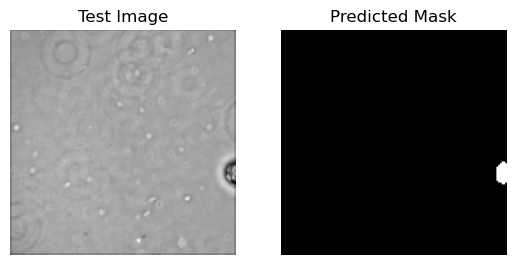

In [ ]:
import random
import matplotlib.pyplot as plt

X_test = torch.Tensor(X_test).permute(0, 2, 3, 1)
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0].cpu()
predicted_mask = preds_test_t[random_index].cpu()
# print(test_image.shape)
# print(predicted_mask.shape)
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[0],cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()

In [ ]:
'''
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_train_cpu = x
Y_train_cpu = y

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow_tensor(X_train_cpu[ix])
imshow_tensor(Y_train_cpu[ix])
imshow_tensor(preds_train_t[ix].cpu())
'''

"\nimport random\nimport torch\nimport matplotlib.pyplot as plt\n\n# Define a function to display images\ndef imshow_tensor(tensor):\n    # Ensure the tensor is on the CPU and convert it to a NumPy array\n    #tensor = tensor.cpu().numpy()\n\n    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)\n    if len(tensor.shape) == 3 and tensor.shape[0] == 1:\n        tensor = tensor.squeeze(0)\n\n    # Display the image\n    plt.imshow(tensor, cmap='gray')\n    plt.show()\n\n# Move your tensors to CPU (if they are not already)\nX_train_cpu = x\nY_train_cpu = y\n\n# Perform a sanity check on some random training samples\nix = random.randint(0, len(preds_train_t))\nimshow_tensor(X_train_cpu[ix])\nimshow_tensor(Y_train_cpu[ix])\nimshow_tensor(preds_train_t[ix].cpu())\n"

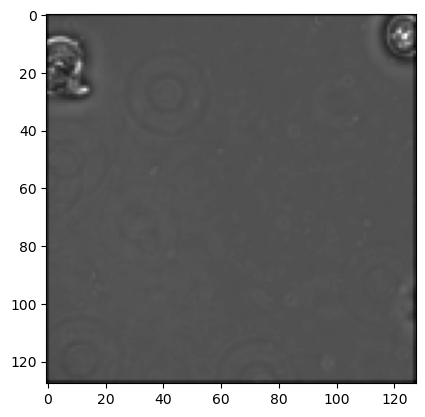

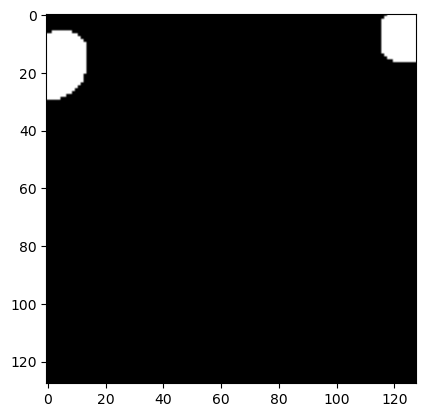

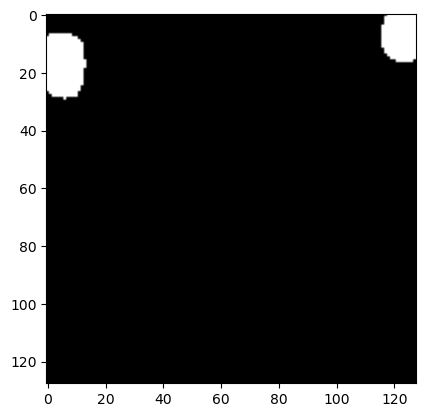

In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t))
imshow_tensor(X_val_cpu[ix,:,:,0])
imshow_tensor(Y_val_cpu[ix])
imshow_tensor(np.squeeze(preds_val_t[ix]).cpu()/255.0)

In [ ]:
# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def prob_to_rles(x, cutoff=0.5):
#     lab_img = label(x > cutoff)
#     for i in range(1, lab_img.max() + 1):
#         yield rle_encoding(lab_img == i)

In [ ]:
# new_test_ids = []
# rles = []
# for n, id_ in enumerate(test_ids):
#     if n > len(preds_test_t) - 1:
#         n = len(preds_test_t) - 1
#     rle = list(prob_to_rles(preds_test_t[n].cpu()))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))

In [ ]:
#print(rles)